## Desert
## Forsake
## Relinquish
## Renounce
## Discard
## Vacate
## Give up
## Quit
## Dump
## ...

### 可视化标注信息

In [2]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from typing import Dict, Tuple, List
import argparse

class VOCDatasetVisualizer:
    def __init__(self, input_dir: str, output_dir: str):
        """
        初始化数据集可视化器
        
        Args:
            input_dir: 输入文件夹路径，需要包含Images和Annotations子文件夹
            output_dir: 输出文件夹路径，用于保存可视化结果
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        
        # 预定义一组醒目的颜色（BGR格式）
        self.predefined_colors = [
            (255, 0, 0),    # 蓝色
            (0, 255, 0),    # 绿色
            (0, 0, 255),    # 红色
            (255, 255, 0),  # 青色
            (255, 0, 255),  # 洋红色
            (0, 255, 255),  # 黄色
            (128, 0, 0),    # 深蓝色
            (0, 128, 0),    # 深绿色
            (0, 0, 128),    # 深红色
            (128, 128, 0),  # 深青色
            (128, 0, 128),  # 深洋红色
            (0, 128, 128),  # 深黄色
            (192, 192, 192),# 浅灰色
            (128, 128, 128),# 灰色
            (128, 0, 255),  # 紫色
        ]
        
        # 检查目录并获取所有类别
        self._check_directories()
        self.categories = self._get_all_categories()
        self.color_map = self._assign_colors()
        
        # 打印类别和对应的颜色
        self._print_category_colors()

    def _check_directories(self) -> None:
        """检查输入文件夹结构是否正确，并创建输出文件夹"""
        # 检查输入文件夹结构
        if not os.path.exists(self.input_dir):
            raise ValueError(f"输入文件夹 {self.input_dir} 不存在！")
            
        images_dir = os.path.join(self.input_dir, 'Images')
        annot_dir = os.path.join(self.input_dir, 'Annotations')
        
        if not (os.path.exists(images_dir) and os.path.exists(annot_dir)):
            raise ValueError("输入文件夹结构不正确！需要包含 'Images' 和 'Annotations' 子文件夹")
            
        # 创建输出文件夹
        os.makedirs(self.output_dir, exist_ok=True)

    def _get_all_categories(self) -> set:
        """
        获取数据集中所有的类别
        
        Returns:
            包含所有类别名称的集合
        """
        categories = set()
        annot_dir = os.path.join(self.input_dir, 'Annotations')
        
        print("正在扫描数据集中的所有类别...")
        for xml_file in os.listdir(annot_dir):
            if not xml_file.endswith('.xml'):
                continue
                
            tree = ET.parse(os.path.join(annot_dir, xml_file))
            root = tree.getroot()
            
            for obj in root.findall('object'):
                try:
                    tree_type = obj.find('tree').text
                    damage_type = obj.find('damage').text
                    category = f"{tree_type}_{damage_type}"
                    categories.add(category)
                except AttributeError as e:
                    print(f"警告：在文件 {xml_file} 中发现无效的标注格式")
                    continue
                
        print(f"找到 {len(categories)} 个类别")
        return categories

    def _assign_colors(self) -> Dict[str, Tuple[int, int, int]]:
        """
        为每个类别分配颜色
        
        Returns:
            类别到颜色的映射字典
        """
        color_map = {}
        for i, category in enumerate(sorted(self.categories)):
            color_idx = i % len(self.predefined_colors)
            color_map[category] = self.predefined_colors[color_idx]
        return color_map

    def _print_category_colors(self) -> None:
        """打印每个类别对应的颜色"""
        print("\n=== 类别和对应的颜色 ===")
        for category, color in self.color_map.items():
            print(f"类别: {category:<15} 颜色: BGR{color}")
        print("=====================\n")

    def parse_xml(self, xml_path: str) -> List[Tuple]:
        """
        解析XML标注文件
        
        Args:
            xml_path: XML文件路径
            
        Returns:
            包含所有标注信息的列表，每个元素为(类别, xmin, ymin, xmax, ymax)
        """
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        
        for obj in root.findall('object'):
            try:
                tree_type = obj.find('tree').text
                damage_type = obj.find('damage').text
                category = f"{tree_type}_{damage_type}"
                
                bbox = obj.find('bndbox')
                xmin = int(float(bbox.find('xmin').text))
                ymin = int(float(bbox.find('ymin').text))
                xmax = int(float(bbox.find('xmax').text))
                ymax = int(float(bbox.find('ymax').text))
                boxes.append((category, xmin, ymin, xmax, ymax))
            except (AttributeError, ValueError) as e:
                print(f"警告：解析XML时发生错误: {str(e)}")
                continue
            
        return boxes

    def visualize(self) -> None:
        """处理数据集中的所有图片和标注"""
        images_dir = os.path.join(self.input_dir, 'Images')
        annot_dir = os.path.join(self.input_dir, 'Annotations')
        
        # 获取所有图片文件
        image_files = [f for f in os.listdir(images_dir) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        total_files = len(image_files)
        
        if total_files == 0:
            print("警告：未找到任何图片文件！")
            return
            
        print(f"\n开始处理 {total_files} 个图片文件...")
        
        # 添加统计信息
        processed_count = 0
        skipped_count = 0
        error_count = 0
        
        for idx, image_name in enumerate(image_files, 1):
            try:
                # 获取图片和对应的XML文件路径
                image_path = os.path.join(images_dir, image_name)
                xml_path = os.path.join(annot_dir, 
                                os.path.splitext(image_name)[0] + '.xml')
                
                if not os.path.exists(xml_path):
                    print(f"警告：找不到 {image_name} 对应的XML文件，跳过该图片")
                    skipped_count += 1
                    continue
                    
                # 读取图片和标注
                image = cv2.imread(image_path)
                if image is None:
                    print(f"警告：无法读取图片 {image_name}，跳过")
                    error_count += 1
                    continue
                    
                boxes = self.parse_xml(xml_path)
                
                # 如果没有标注框，可能是问题数据
                if not boxes:
                    print(f"警告：{image_name} 没有标注框，可能需要检查")
                
                # 在图片上绘制标注框
                for category, xmin, ymin, xmax, ymax in boxes:
                    # 确保坐标不越界
                    height, width = image.shape[:2]
                    xmin = max(0, min(xmin, width-1))
                    ymin = max(0, min(ymin, height-1))
                    xmax = max(0, min(xmax, width-1))
                    ymax = max(0, min(ymax, height-1))
                    
                    color = self.color_map[category]
                    
                    # 绘制边界框
                    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
                    
                    # 准备标签文本
                    label = category
                    
                    # 获取文本大小
                    (text_width, text_height), baseline = cv2.getTextSize(
                        label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                    
                    # 确保标签背景矩形不会超出图像边界
                    text_ymin = max(0, ymin - text_height - 10)
                    
                    # 绘制标签背景矩形
                    cv2.rectangle(image, 
                                (xmin, text_ymin),
                                (min(xmin + text_width + 10, width-1), ymin),
                                color, -1)
                    
                    # 绘制白色文本
                    cv2.putText(image, label,
                            (xmin + 5, ymin - 5),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.6, (255, 255, 255), 1)
                
                # 保存结果
                output_path = os.path.join(self.output_dir, image_name)
                cv2.imwrite(output_path, image)
                
                processed_count += 1
                
                # 打印进度
                print(f"处理进度: [{idx}/{total_files}] {image_name}")
                
            except Exception as e:
                print(f"处理 {image_name} 时发生错误: {str(e)}")
                error_count += 1
                continue
        
        # 打印最终统计信息
        print("\n处理完成！统计信息：")
        print(f"总文件数: {total_files}")
        print(f"成功处理: {processed_count}")
        print(f"跳过文件: {skipped_count}")
        print(f"错误文件: {error_count}")

def main():
    """主函数"""
    input_dir = "./Viken_20180918_damage"
    output_dir = "Viken_20180918_damage_visualized"
    
    try:
        visualizer = VOCDatasetVisualizer(input_dir, output_dir)
        visualizer.visualize()
        print("\n可视化完成！输出结果保存在:", visualizer.output_dir)
    except Exception as e:
        print(f"错误：{str(e)}")

if __name__ == '__main__':
    main()

正在扫描数据集中的所有类别...
找到 6 个类别

=== 类别和对应的颜色 ===
类别: Aspen_other     颜色: BGR(255, 0, 0)
类别: Birch_other     颜色: BGR(0, 255, 0)
类别: Other_other     颜色: BGR(0, 0, 255)
类别: Pine_other      颜色: BGR(255, 255, 0)
类别: Spruce_HD       颜色: BGR(255, 0, 255)
类别: Spruce_other    颜色: BGR(0, 255, 255)


开始处理 112 个图片文件...
处理进度: [1/112] 023279fc-cc58-49ca-89da-8d7e3ef63ce0.jpg
处理进度: [2/112] 02404815-8062-4b31-86d9-a10b205858f6.jpg
处理进度: [3/112] 0545c953-43fa-4ee8-b4d8-dad4faaa72e0.jpg
处理进度: [4/112] 06476548-d3f2-447c-ab3a-8efd7de124d6.jpg
处理进度: [5/112] 0b5e86d9-9a46-441d-a440-2e062b2b9378.jpg
处理进度: [6/112] 0cf27fdf-acf2-4576-ab50-691c3879ec8d.jpg
处理进度: [7/112] 0d002d31-e1ec-4866-98a6-123e33183f96.jpg
处理进度: [8/112] 0f484898-e1a3-4f66-a189-e3f3d7a24729.jpg
处理进度: [9/112] 0f81ee69-4b1e-44b3-91df-a9a9dda7fec1.jpg
处理进度: [10/112] 12b25606-1fa6-47a4-8cad-dc7ccae14d7b.jpg
处理进度: [11/112] 172d8950-2d44-4243-9bae-1c9b0258e6c5.jpg
处理进度: [12/112] 195040a2-e8d4-48a8-8f8d-c9081912934b.jpg
处理进度: [13/112] 1b64e023-1d8d-44c3

### 转化为标准的voc格式的xml标注文件
- 最后要整理成voc格式 ，先将标注格式标准化

In [ ]:
import os
import xml.etree.ElementTree as ET
from shutil import copyfile
import datetime

class XMLConverter:
    def __init__(self, input_dir: str, backup_dir: str = None):
        """
        初始化XML转换器
        
        Args:
            input_dir: 包含XML文件的输入目录
            backup_dir: 备份目录（如果不指定，将在input_dir旁创建带时间戳的备份目录）
        """
        self.input_dir = input_dir
        
        # 如果未指定备份目录，创建带时间戳的备份目录
        if backup_dir is None:
            timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
            self.backup_dir = f"{input_dir}_backup_{timestamp}"
        else:
            self.backup_dir = backup_dir
            
        self.annotations_dir = os.path.join(input_dir, 'Annotations')
        
        # 检查目录
        self._check_directories()

    def _check_directories(self):
        """检查并创建必要的目录"""
        if not os.path.exists(self.annotations_dir):
            raise ValueError(f"标注目录不存在: {self.annotations_dir}")
            
        # 创建备份目录
        backup_annotations_dir = os.path.join(self.backup_dir, 'Annotations')
        os.makedirs(backup_annotations_dir, exist_ok=True)
        print(f"创建备份目录: {self.backup_dir}")

    def backup_xml(self, xml_file: str):
        """
        备份单个XML文件
        
        Args:
            xml_file: XML文件名
        """
        src = os.path.join(self.annotations_dir, xml_file)
        dst = os.path.join(self.backup_dir, 'Annotations', xml_file)
        copyfile(src, dst)

    def convert_xml(self, xml_file: str):
        """
        转换单个XML文件为标准VOC格式
        
        Args:
            xml_file: XML文件名
        """
        xml_path = os.path.join(self.annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # 处理每个object元素
        for obj in root.findall('object'):
            # 获取树种和损伤类型
            tree_type = obj.find('tree')
            damage_type = obj.find('damage')
            
            if tree_type is not None and damage_type is not None:
                # 创建新的name元素
                name = ET.Element('name')
                name.text = f"{tree_type.text}_{damage_type.text}"
                
                # 删除原有的tree和damage元素
                obj.remove(tree_type)
                obj.remove(damage_type)
                
                # 将name元素插入到object的开头
                obj.insert(0, name)
        
        # 保存修改后的XML
        tree.write(xml_path, encoding='utf-8', xml_declaration=True)

    def convert_all(self):
        """转换所有XML文件"""
        xml_files = [f for f in os.listdir(self.annotations_dir) if f.endswith('.xml')]
        total_files = len(xml_files)
        
        print(f"开始处理 {total_files} 个XML文件...")
        
        for idx, xml_file in enumerate(xml_files, 1):
            try:
                # 首先备份
                self.backup_xml(xml_file)
                
                # 然后转换
                self.convert_xml(xml_file)
                
                print(f"处理进度: [{idx}/{total_files}] {xml_file}")
                
            except Exception as e:
                print(f"处理 {xml_file} 时发生错误: {str(e)}")
                continue
        
        print("\n处理完成！")
        print(f"原文件已备份到: {self.backup_dir}")

def main():
    """主函数"""
    input_dir = "./Viken_20180918_damage"  # 修改为你的输入目录
    
    try:
        converter = XMLConverter(input_dir)
        converter.convert_all()
    except Exception as e:
        print(f"错误：{str(e)}")

if __name__ == '__main__':
    main()

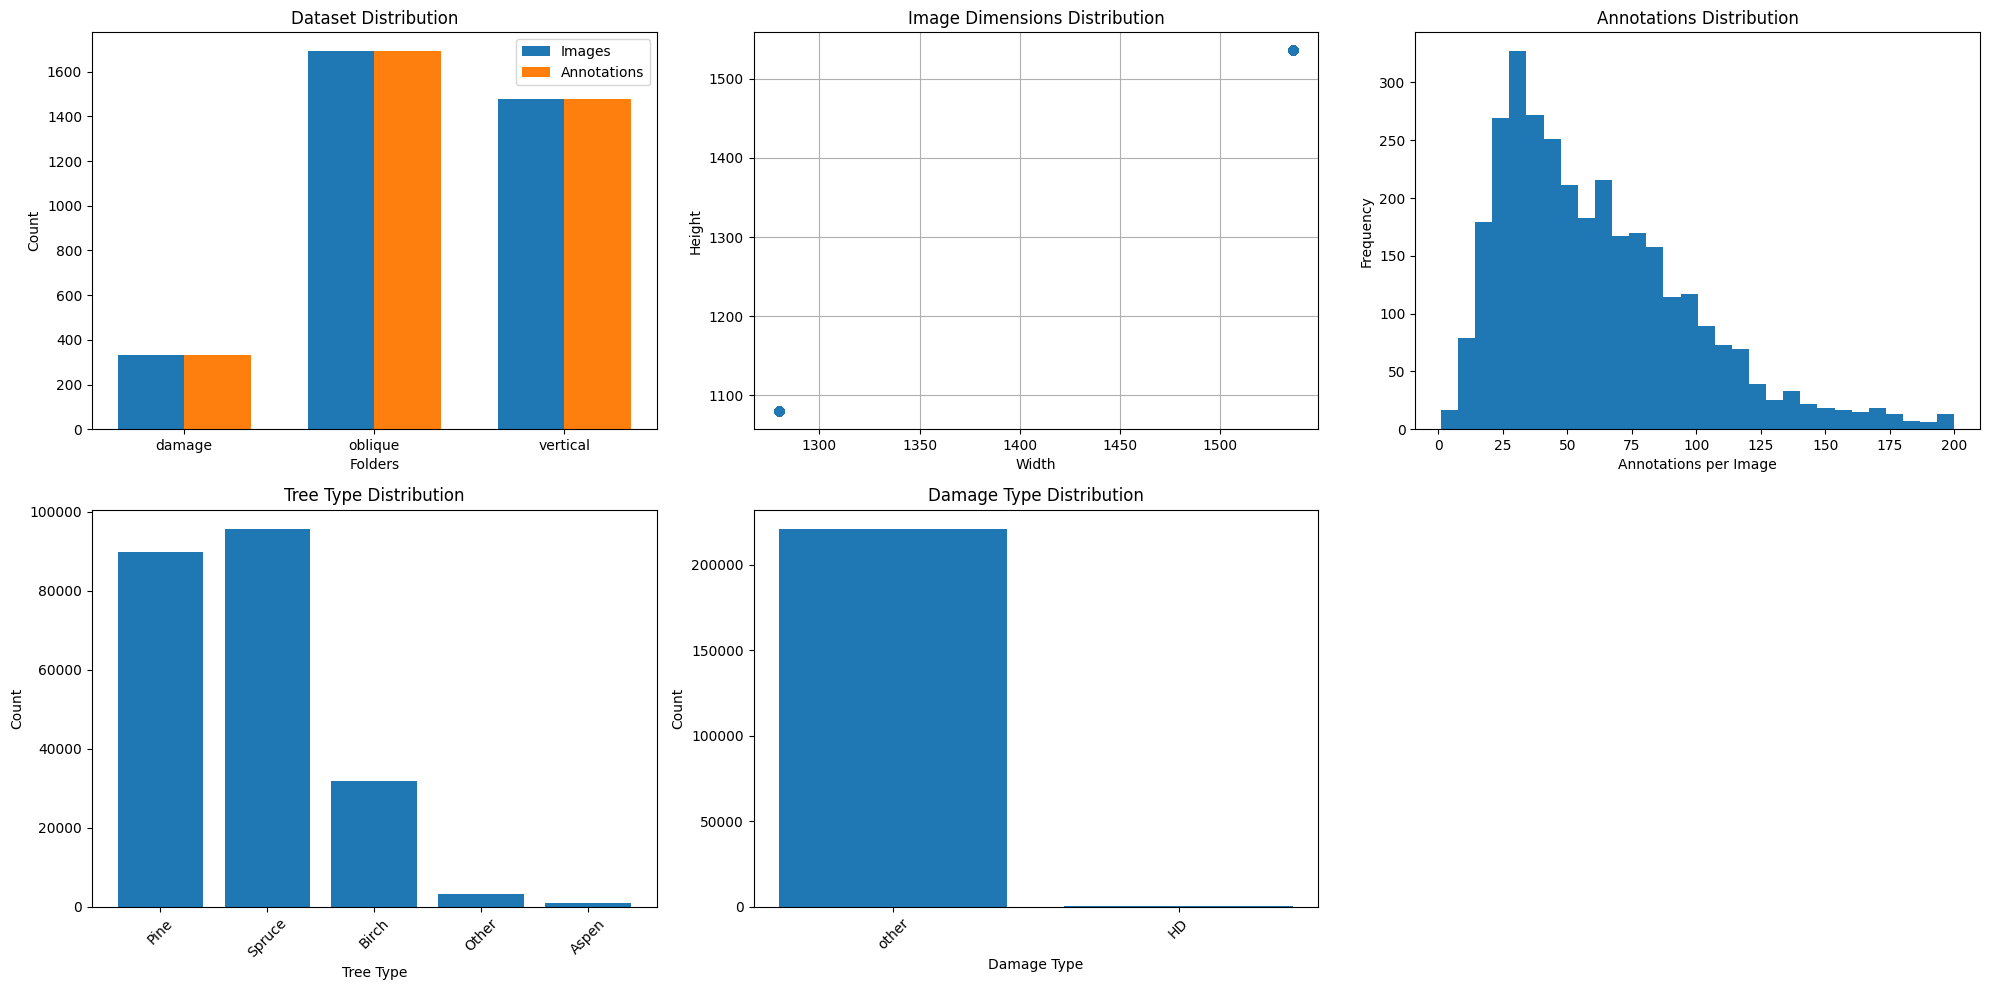


=== 数据集统计 ===
damage文件夹:
  图片数量: 331
  标注文件数量: 331
oblique文件夹:
  图片数量: 1692
  标注文件数量: 1692
vertical文件夹:
  图片数量: 1478
  标注文件数量: 1478

树木类型统计:
  Pine: 89782
  Spruce: 95719
  Birch: 31770
  Other: 3306
  Aspen: 848

损伤类型统计:
  other: 220942
  HD: 483
Visualizing random image: Data_Set_Spruce_Bark_Beetle\vertical\Lidhem_20201001\Images\b2e1d486-8497-48d5-86ff-b37dbdea7bbc.jpg


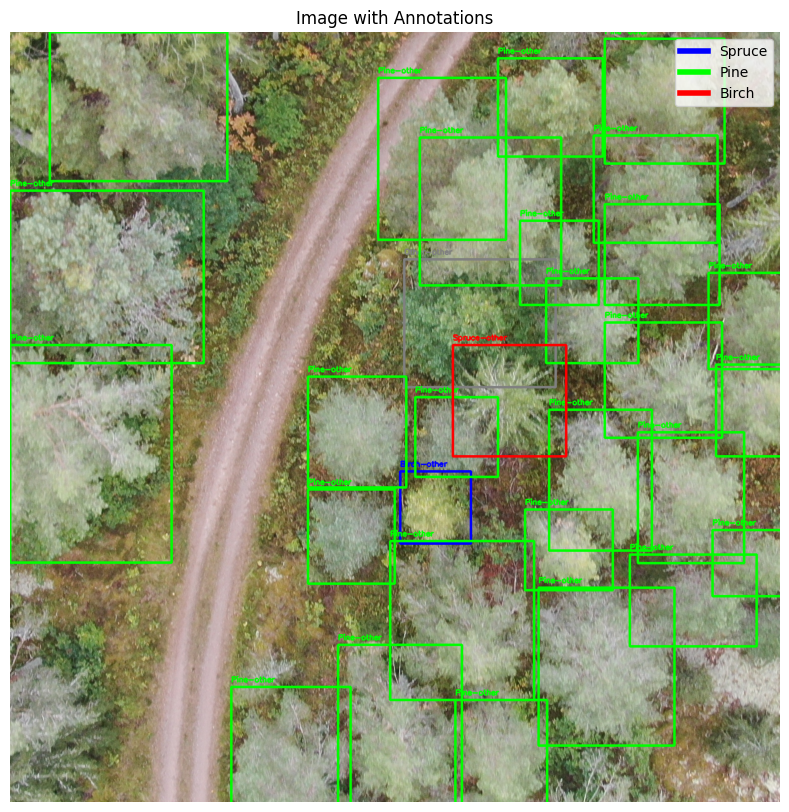

In [3]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import cv2
import xml.etree.ElementTree as ET

def read_image(image_path):
    """读取图片文件"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error reading image {image_path}: {e}")
        return None

def parse_xml_annotation(xml_path):
    """解析XML标注文件"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    annotations = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        if bbox is not None:
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            
            tree_type = obj.find('tree').text if obj.find('tree') is not None else 'Unknown'
            damage_type = obj.find('damage').text if obj.find('damage') is not None else 'Unknown'
            
            annotations.append({
                'bbox': [xmin, ymin, xmax-xmin, ymax-ymin],
                'tree_type': tree_type,
                'damage_type': damage_type
            })
    
    return annotations

def visualize_annotation(image_path, xml_path, output_path=None):
   """可视化单张图片的标注，相同类别使用相同颜色"""
   # 读取图片
   image = read_image(image_path)
   if image is None:
       return
   
   # 读取标注
   annotations = parse_xml_annotation(xml_path)
   
   # 创建图像副本用于绘制
   vis_image = image.copy()
   
   # 为每种树木类型定义固定颜色
   color_map = {
       'Spruce': (255, 0, 0),    # 红色-云杉
       'Pine': (0, 255, 0),      # 绿色-松树
       'Birch': (0, 0, 255),     # 蓝色-桦树
       'Aspen': (255, 255, 0),   # 黄色-白杨
       'Unknown': (128, 128, 128) # 灰色-未知
   }
   
   # 绘制每个标注
   for ann in annotations:
       # 获取树木类型对应的颜色
       tree_type = ann['tree_type']
       color = color_map.get(tree_type, (128, 128, 128))  # 如果类型未定义，使用灰色
       
       # 绘制边界框
       x, y, w, h = ann['bbox']
       cv2.rectangle(vis_image, (x, y), (x+w, y+h), color, 4)
       
       # 添加标签文本
       label = f"{tree_type}-{ann['damage_type']}"
       cv2.putText(vis_image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, color, 2)
   
   # 显示结果
   plt.figure(figsize=(15, 10))
   plt.imshow(vis_image)
   plt.axis('off')
   plt.title('Image with Annotations')
   
   # 添加图例
   legend_elements = [plt.Line2D([0], [0], color=[c[2]/255, c[1]/255, c[0]/255], 
                                label=t, linewidth=4) 
                     for t, c in color_map.items() 
                     if any(ann['tree_type'] == t for ann in annotations)]
   plt.legend(handles=legend_elements, loc='upper right')
   
   if output_path:
       plt.savefig(output_path)
   plt.show()

def analyze_dataset(base_path):
    """分析数据集统计信息并可视化"""
    folders = ['damage', 'oblique', 'vertical']
    image_counts = []
    annotation_counts = []
    all_image_sizes = []
    annotations_per_image = defaultdict(int)
    tree_types = defaultdict(int)
    damage_types = defaultdict(int)
    
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        total_images = 0
        total_annotations = 0
        
        # 遍历子文件夹
        for subdir in os.listdir(folder_path):
            subdir_path = os.path.join(folder_path, subdir)
            if os.path.isdir(subdir_path):
                # 统计Images文件夹
                images_path = os.path.join(subdir_path, 'Images')
                if os.path.exists(images_path):
                    image_files = [f for f in os.listdir(images_path) 
                                 if f.endswith(('.jpg', '.png', '.tif'))]
                    total_images += len(image_files)
                    
                    # 收集图片尺寸信息
                    for img_file in image_files:
                        img_path = os.path.join(images_path, img_file)
                        try:
                            with Image.open(img_path) as img:
                                all_image_sizes.append(img.size)
                        except Exception as e:
                            print(f"Error processing {img_path}: {e}")
                
                # 统计Annotations文件夹
                annotations_path = os.path.join(subdir_path, 'Annotations')
                if os.path.exists(annotations_path):
                    xml_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]
                    total_annotations += len(xml_files)
                    
                    # 分析标注内容
                    for xml_file in xml_files:
                        xml_path = os.path.join(annotations_path, xml_file)
                        annotations = parse_xml_annotation(xml_path)
                        annotations_per_image[xml_file] = len(annotations)
                        
                        # 统计树木类型和损伤类型
                        for ann in annotations:
                            tree_types[ann['tree_type']] += 1
                            damage_types[ann['damage_type']] += 1
        
        image_counts.append(total_images)
        annotation_counts.append(total_annotations)
    
    # 可视化统计信息
    plt.figure(figsize=(20, 10))
    
    # 1. 数据集分布
    plt.subplot(231)
    x = np.arange(len(folders))
    width = 0.35
    
    plt.bar(x - width/2, image_counts, width, label='Images')
    plt.bar(x + width/2, annotation_counts, width, label='Annotations')
    
    plt.xlabel('Folders')
    plt.ylabel('Count')
    plt.title('Dataset Distribution')
    plt.xticks(x, folders)
    plt.legend()
    
    # 2. 图像尺寸分布
    plt.subplot(232)
    widths, heights = zip(*all_image_sizes)
    plt.scatter(widths, heights, alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Dimensions Distribution')
    plt.grid(True)
    
    # 3. 每张图片的标注数量分布
    plt.subplot(233)
    plt.hist(list(annotations_per_image.values()), bins=30)
    plt.xlabel('Annotations per Image')
    plt.ylabel('Frequency')
    plt.title('Annotations Distribution')
    
    # 4. 树木类型分布
    plt.subplot(234)
    plt.bar(tree_types.keys(), tree_types.values())
    plt.xticks(rotation=45)
    plt.xlabel('Tree Type')
    plt.ylabel('Count')
    plt.title('Tree Type Distribution')
    
    # 5. 损伤类型分布
    plt.subplot(235)
    plt.bar(damage_types.keys(), damage_types.values())
    plt.xticks(rotation=45)
    plt.xlabel('Damage Type')
    plt.ylabel('Count')
    plt.title('Damage Type Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("\n=== 数据集统计 ===")
    for folder, imgs, anns in zip(folders, image_counts, annotation_counts):
        print(f"{folder}文件夹:")
        print(f"  图片数量: {imgs}")
        print(f"  标注文件数量: {anns}")
    
    print("\n树木类型统计:")
    for tree_type, count in tree_types.items():
        print(f"  {tree_type}: {count}")
    
    print("\n损伤类型统计:")
    for damage_type, count in damage_types.items():
        print(f"  {damage_type}: {count}")

def random_visualization(base_path):
    """随机选择一张图片进行可视化"""
    folders = ['damage', 'oblique', 'vertical']
    all_image_paths = []
    all_xml_paths = []
    
    # 收集所有图片和标注文件路径
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for subdir in os.listdir(folder_path):
            subdir_path = os.path.join(folder_path, subdir)
            if os.path.isdir(subdir_path):
                images_path = os.path.join(subdir_path, 'Images')
                annotations_path = os.path.join(subdir_path, 'Annotations')
                
                if os.path.exists(images_path) and os.path.exists(annotations_path):
                    for img_file in os.listdir(images_path):
                        if img_file.endswith(('.jpg', '.png', '.tif')):
                            xml_file = os.path.splitext(img_file)[0] + '.xml'
                            xml_path = os.path.join(annotations_path, xml_file)
                            
                            if os.path.exists(xml_path):
                                all_image_paths.append(os.path.join(images_path, img_file))
                                all_xml_paths.append(xml_path)
    
    if all_image_paths:
        # 随机选择一张图片
        idx = random.randint(0, len(all_image_paths) - 1)
        img_path = all_image_paths[idx]
        xml_path = all_xml_paths[idx]
        
        print(f"Visualizing random image: {img_path}")
        visualize_annotation(img_path, xml_path)
    else:
        print("No valid image-annotation pairs found.")

if __name__ == "__main__":
    dataset_path = "Data_Set_Spruce_Bark_Beetle"  # 替换为你的数据集根目录路径
    analyze_dataset(dataset_path)
    random_visualization(dataset_path)